# Playground

In [1]:
# nasty hack for Colab
![ -n $COLAB_RELEASE_TAG ] && git clone -b madziejm-dev https://github.com/madziejm/0nmt.git
![ -n $COLAB_RELEASE_TAG ] && pip install -r ./0nmt/requirements.txt
try:
  import google.colab
  import sys
  sys.path.insert(0, '/content/0nmt')
except Exception as e:
  print(e)

fatal: destination path '0nmt' already exists and is not an empty directory.


Ignoring colorama: markers 'python_version >= "3.10" and python_version < "4.0" and platform_system == "Windows" or python_version >= "3.10" and python_version < "4.0" and sys_platform == "win32"' don't match your environment

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
No module named 'google.colab'


In [2]:
import io
from collections import Counter
from pathlib import Path
from typing import List

import pytorch_lightning as pl
import pytorch_lightning.callbacks as plc
import torch
from icecream import ic
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive
from torchtext.vocab import FastText, vocab

from zeronmt.models.datatypes import DimensionSpec, Language, Vectors
from zeronmt.models.seq2seq import Seq2Seq

In [3]:
# MAPPING_PATH = Path(
#     "/home/maciej/github/bachelor-thesis/project/vecs/le0n8xvt7l/best_mapping.pth"
# )

In [4]:
# # TODO
# mapping = torch.load(MAPPING_PATH)

# cs_vecs = MappedFastTextVectors(language="cs", mapping=None)
# pl_vecs = MappedFastTextVectors(language="pl", mapping=mapping)

`src` means DE.  
`tgt` means ENG.

In [5]:
class FastTextPretrainedAligned(FastText):
    url_base = (
        "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.{}.align.vec"
    )
    # url_base = "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.{}.align.vec"

    def __init__(self, language: str, special_toks: List[str], **kwargs) -> None:
        super().__init__(language, **kwargs)

        # prepend specials tokens
        self.itos[0:0] = special_toks

        # hopefully it is not slow :)
        self.stoi = {
            **dict(zip(special_toks, range(len(special_toks)))),
            **{word: i + len(special_toks) for i, word in enumerate(self.stoi)},
        }

        # the vectors for the special tokens here will not be used by the model
        # we set them to zeros so indexing works flawlessly
        vecs_special_toks = torch.zeros(len(special_toks), self.dim)
        self.vectors = torch.cat((vecs_special_toks, self.vectors), dim=0)
        assert len(self.vectors) == len(self.itos)
        assert len(self.vectors) == len(self.stoi)

In [6]:
VOCAB_SIZE = int(4.5e4)  # top 50K words only

In [7]:
specials = ["<unk>", "<pad>", "<bos>", "<eos>"]

tgt_vecs = FastTextPretrainedAligned(
    language="en", special_toks=specials, max_vectors=VOCAB_SIZE
)
src_vecs = FastTextPretrainedAligned(
    language="de", special_toks=specials, max_vectors=VOCAB_SIZE
)

tgt_vocab = vocab(tgt_vecs.stoi, min_freq=0)
src_vocab = vocab(src_vecs.stoi, min_freq=0)

In [8]:
src_vocab.set_default_index(src_vocab["<unk>"])
tgt_vocab.set_default_index(tgt_vocab["<unk>"])

In [9]:
ic(src_vecs.stoi["<unk>"])
ic(src_vecs.stoi["<pad>"])
ic(src_vecs.stoi["<bos>"])
ic(src_vecs.stoi["<eos>"])

ic| src_vecs.stoi["<unk>"]: 0
ic| src_vecs.stoi["<pad>"]: 1
ic| src_vecs.stoi["<bos>"]: 2
ic| src_vecs.stoi["<eos>"]: 3


3

In [10]:
BATCH_SIZE = 64

# special tokens are prepended, so these indices are the same for both the languages
PAD_IDX = src_vocab["<pad>"]
BOS_IDX = src_vocab["<bos>"]
EOS_IDX = src_vocab["<eos>"]

In [11]:
ic(PAD_IDX)
ic(BOS_IDX)
ic(EOS_IDX)

ic| PAD_IDX: 1
ic| BOS_IDX: 2
ic| EOS_IDX: 3


3

In [12]:
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
opensubtitles_url = "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/de-en.txt.zip"
test_urls = tuple(
    "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
    + filename
    for filename in ("test_2016_flickr.de.gz", "test_2016_flickr.en.gz")
)

opensubtitles_filepaths = tuple(
    fp
    for fp in extract_archive(download_from_url(opensubtitles_url))
    if any(f in fp for f in ("OpenSubtitles.de-en.en", "OpenSubtitles.de-en.de"))
)

test_filepaths = [extract_archive(download_from_url(url))[0] for url in test_urls]

tokenizer = get_tokenizer("basic_english")  # keep it simple

In [15]:
class ParallelDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        src_filepath: str,
        tgt_filepath: str,
        min_sentence_len=3,
        max_sentence_len=100,
        max_nsentence=float("inf"),
    ):
        raw_src_iter = iter(io.open(src_filepath, encoding="utf8"))
        raw_tgt_iter = iter(io.open(tgt_filepath, encoding="utf8"))

        self.lens_src = []
        self.lens_tgt = []

        self.src = []
        self.tgt = []
        for i, (raw_de, raw_en) in enumerate(zip(raw_src_iter, raw_tgt_iter)):
            if i >= max_nsentence:
                break
            src_tensor_ = torch.tensor(
                [src_vocab[token] for token in tokenizer(raw_de)], dtype=torch.long
            )
            tgt_tensor_ = torch.tensor(
                [tgt_vocab[token] for token in tokenizer(raw_en)], dtype=torch.long
            )
            self.lens_src.append(len(src_tensor_))
            self.lens_tgt.append(len(tgt_tensor_))
            if (
                min_sentence_len <= len(src_tensor_)
                and len(src_tensor_) <= max_sentence_len
                and min_sentence_len <= len(tgt_tensor_)
                and len(tgt_tensor_) <= max_sentence_len
            ):
                self.src.append(src_tensor_)
                self.tgt.append(tgt_tensor_)

    def __len__(self):
        return len(self.src)

    def __getitem__(self, index):
        return self.src[index], self.tgt[index]

In [16]:
train_val_data = ParallelDataset(*opensubtitles_filepaths, max_sentence_len=100, max_nsentence=1e6)
test_data = ParallelDataset(*test_filepaths, max_sentence_len=100, max_nsentence=1e6)

In [17]:
ic(len(train_val_data))
ic(len(test_data))


ic| len(train_val_data): 930389
ic| len(test_data): 1000


1000

In [19]:
import numpy as np
from matplotlib import pyplot as plt

[]

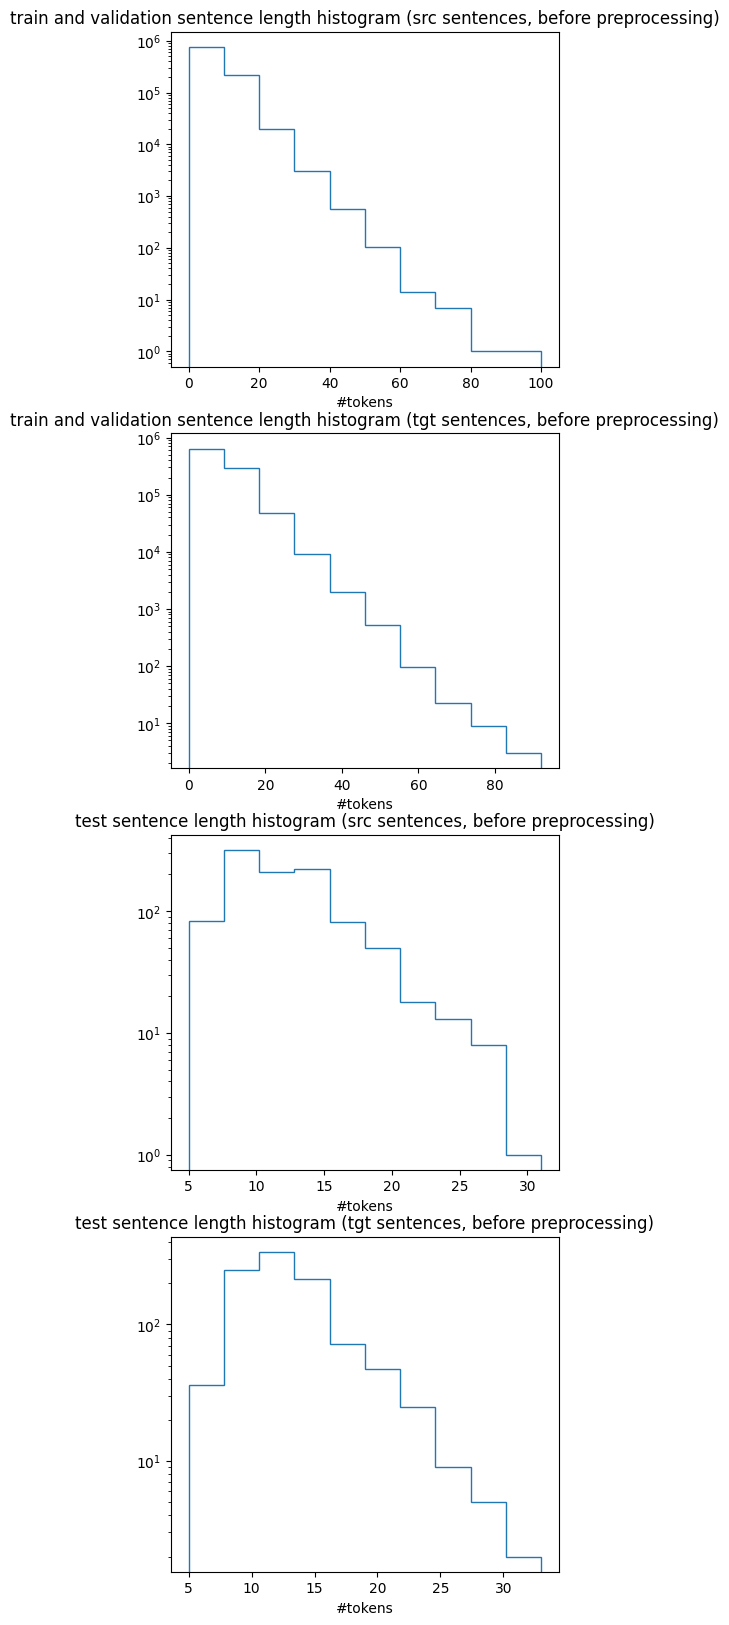

In [20]:
fig, axs = plt.subplots(nrows=4, figsize=(5, 4 * 5))

for i, (hist_title, data) in enumerate(
    (("train and validation", train_val_data), ("test", test_data))
):
    counts, bins = np.histogram(data.lens_src)
    axs[2 * i].stairs(counts, bins)
    axs[2 * i].set_title(hist_title + " sentence length histogram (src sentences, before preprocessing)")
    axs[2 * i].set_yscale('log')
    axs[2 * i].set_xlabel('count (log)')
    axs[2 * i].set_xlabel('#tokens')
    counts, bins = np.histogram(data.lens_tgt)
    axs[2 * i + 1].stairs(counts, bins)
    axs[2 * i + 1].set_title(hist_title + " sentence length histogram (tgt sentences, before preprocessing)")
    axs[2 * i + 1].set_yscale('log')
    axs[2 * i + 1].set_xlabel('count (log)')
    axs[2 * i + 1].set_xlabel('#tokens')

    del data.lens_src
    del data.lens_tgt

plt.plot()

In [21]:
model = Seq2Seq(
    DEC_DROPOUT,
    ENC_DROPOUT,
    DimensionSpec(
        attention=ATTN_DIM,
        dec_hid=DEC_HID_DIM,
        enc_hid=ENC_HID_DIM,
        nspecial_toks=len(specials),
    ),
    PAD_IDX,
    Vectors(src_vecs, tgt_vecs),
)

embedding_src.weight
embedding_tgt.weight
encoder.special_toks_embedding.weight
encoder.rnn.weight_ih_l0
encoder.rnn.weight_hh_l0
encoder.rnn.bias_ih_l0
encoder.rnn.bias_hh_l0
encoder.rnn.weight_ih_l0_reverse
encoder.rnn.weight_hh_l0_reverse
encoder.rnn.bias_ih_l0_reverse
encoder.rnn.bias_hh_l0_reverse
encoder.fc.weight
encoder.fc.bias
decoder.attention.attn.weight
decoder.attention.attn.bias
decoder.special_toks_embedding.weight
decoder.rnn.weight_ih_l0
decoder.rnn.weight_hh_l0
decoder.rnn.bias_ih_l0
decoder.rnn.bias_hh_l0
decoder.output_to_src.weight
decoder.output_to_src.bias
decoder.output_to_tgt.weight
decoder.output_to_tgt.bias


In [22]:
model

Seq2Seq(
  (embedding_src): Embedding(45004, 300)
  (embedding_tgt): Embedding(45004, 300)
  (encoder): Encoder(
    (embedding_src): Embedding(45004, 300)
    (embedding_tgt): Embedding(45004, 300)
    (special_toks_embedding): Embedding(4, 300, padding_idx=1)
    (rnn): GRU(300, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding_src): Embedding(45004, 300)
    (embedding_tgt): Embedding(45004, 300)
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=8, bias=True)
    )
    (special_toks_embedding): Embedding(4, 300, padding_idx=1)
    (rnn): GRU(428, 64)
    (output_to_src): Linear(in_features=492, out_features=45004, bias=True)
    (output_to_tgt): Linear(in_features=492, out_features=45004, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

In [23]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [24]:
def collate_batch(data_batch):
    src_batch, tgt_batch = [], []
    for src_item, tgt_item in data_batch:
        src_batch.append(
            torch.cat(
                [torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0
            )
        )
        tgt_batch.append(
            torch.cat(
                [torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0
            )
        )
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [25]:
train_data, val_data = torch.utils.data.random_split(train_val_data, [0.8, 0.2])

In [26]:
ic(len(train_data))
ic(len(val_data))

ic| len(train_data): 744312
ic| len(val_data): 186077


186077

In [27]:
train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=0,
)
valid_dl = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=0,
)
test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=0,
)

In [28]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
wandb_logger = WandbLogger(project="0nmt", log_model="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: 81bcd48a2 (0nmt). Use `wandb login --relogin` to force relogin


In [29]:
trainer = pl.Trainer(
    gradient_clip_val=1.0,
    max_epochs=5,
    callbacks=[plc.TQDMProgressBar(refresh_rate=5), checkpoint_callback],
    logger=wandb_logger
)
trainer.fit(model, train_dataloaders=[train_dl], val_dataloaders=[valid_dl], )

In [ ]:
import wandb
wandb.finish()

In [ ]:
src_in = torch.tensor(
    [src_vocab[token] for token in tokenizer("<bos> ich liebe kartoffeln <eos>")]
).unsqueeze(1)
tgt_in = torch.tensor(
    [tgt_vocab[token] for token in tokenizer("<bos> i love potatoes <eos>")]
).unsqueeze(
    1
)  # actually unused
ic(src_in.shape)
ic(src_in)
ic(tgt_in.shape)
ic(tgt_in)

ic| src_in.shape: torch.Size([5, 1])
ic| src_in: tensor([[    2],
                    [   47],
                    [  969],
                    [15732],
                    [    3]])
ic| tgt_in.shape: torch.Size([5, 1])
ic| tgt_in: tensor([[    2],
                    [   32],
                    [  571],
                    [14391],
                    [    3]])


tensor([[    2],
        [   32],
        [  571],
        [14391],
        [    3]])

In [ ]:
ic(torch.tensor(tuple(tgt_vocab["<bos>"] for _ in src_in[:, 0])).unsqueeze(-1).shape)
ic(torch.tensor(tuple(tgt_vocab["<bos>"] for _ in src_in[:, 0])).unsqueeze(-1))

ic| torch.tensor(tuple(tgt_vocab["<bos>"] for _ in src_in[:, 0])).unsqueeze(-1).shape: torch.Size([5, 1])
ic| torch.tensor(tuple(tgt_vocab["<bos>"] for _ in src_in[:, 0])).unsqueeze(-1): tensor([[2],
                                                                                         [2],
                                                                                         [2],
                                                                                         [2],
                                                                                         [2]])


tensor([[2],
        [2],
        [2],
        [2],
        [2]])

In [ ]:
tgt_in.shape
ic(tgt_in)

ic| tgt_in: tensor([[    2],
                    [   32],
                    [  571],
                    [14391],
                    [    3]])


tensor([[    2],
        [   32],
        [  571],
        [14391],
        [    3]])

In [ ]:
output = model(src_in, tgt_in, Language.src, Language.tgt, teacher_forcing_ratio=0)
torch.set_printoptions(profile="full")
predicted_tokens = output.argmax(-1)
ic(output.shape)
ic(predicted_tokens.shape)
ic(predicted_tokens)
ic([tgt_vocab.get_itos()[t] for t in predicted_tokens])

ic| output.shape: torch.Size([5, 1, 50004])
ic| predicted_tokens.shape: torch.Size([5, 1])
ic| predicted_tokens: tensor([[   0],
                              [  25],
                              [6329],
                              [6329],
                              [6329]])
ic| [tgt_vocab.get_itos()[t] for t in predicted_tokens]: ['<unk>', 'it', 'su', 'su', 'su']


['<unk>', 'it', 'su', 'su', 'su']

In [ ]:
output = model(
    src_in,
    torch.tensor(tuple(tgt_vocab["<bos>"] for _ in src_in[:, 0])).unsqueeze(-1),
    Language.src,
    Language.tgt,
    teacher_forcing_ratio=0,
)
torch.set_printoptions(profile="full")
predicted_tokens = output.argmax(-1)
ic(output.shape)
ic(predicted_tokens.shape)
ic(predicted_tokens)
ic([tgt_vocab.get_itos()[t] for t in predicted_tokens])

ic| output.shape: torch.Size([5, 1, 50004])
ic| predicted_tokens.shape: torch.Size([5, 1])
ic| predicted_tokens: tensor([[    0],
                              [   25],
                              [28431],
                              [28431],
                              [28431]])
ic| [tgt_vocab.get_itos()[t] for t in predicted_tokens]: ['<unk>', 'it', 'agonist', 'agonist', 'agonist']


['<unk>', 'it', 'agonist', 'agonist', 'agonist']

In [ ]:
for src_in, tgt_in in valid_dl:
    ic(src_in.shape)
    ic(tgt_in.shape)
    src_in = src_in[:, 0].unsqueeze(-1)  # first item in the batch only
    tgt_in = tgt_in[:, 0].unsqueeze(-1)  # first item in the batch only
    ic(src_in.shape)
    ic(tgt_in.shape)
    ic(src_in[:, 0])
    ic(tgt_in[:, 0])
    break
output = model(src_in, tgt_in,  Language.src, Language.tgt, teacher_forcing_ratio=0)
torch.set_printoptions(profile="full")
predicted_tokens = output.argmax(-1)
ic(output.shape)
ic(predicted_tokens.shape)
ic(predicted_tokens[:, 0])  # get first batch here
ic(
    [src_vocab.get_itos()[t] for t in src_in[:12]]
)  # limit tokens to first 12 for better presentation
ic(
    [tgt_vocab.get_itos()[t] for t in predicted_tokens[:12]]
)  # limit tokens to first 12 for better presentation

ic| src_in.shape: torch.Size([23, 128])
ic| tgt_in.shape: torch.Size([25, 128])
ic| src_in.shape: torch.Size([23, 1])
ic| tgt_in.shape: torch.Size([25, 1])
ic| src_in[:, 0]: tensor([   2, 1695,   21,   34,   66,    8,    0,    5,  203,   32,    8,    0,
                             4,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1])
ic| tgt_in[:, 0]: tensor([    2,    11,    29,    17,     6, 25597,     4,     6, 27690,     5,
                              3,     1,     1,     1,     1,     1,     1,     1,     1,     1,
                              1,     1,     1,     1,     1])
ic| output.shape: torch.Size([25, 1, 50004])
ic| predicted_tokens.shape: torch.Size([25, 1])
ic| predicted_tokens[:, 0]: tensor([ 0, 25, 35, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                                     1,  1,  1,  1,  1,  1,  1])
ic| [src_vocab.get_itos()[t] for t in src_in[:12]]: ['<bos>',
                                                     'gott',
          

['<unk>',
 'it',
 'his',
 'it',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']